# **Finding Lane Lines on the Road** 

**Related algorithm:
color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.
**


In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


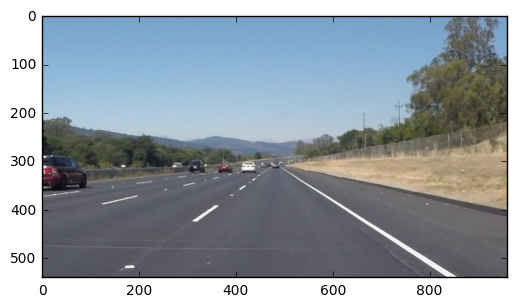

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    h,w = img.shape[0],img.shape[1]
    
    min_y = int(0.6*h)
    max_y = h
    #------Separate the detected lines by their slope-----
    left = []
    right = []
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    #  ----FOR DEBUG.TO SEE WHICH LINE IS WRONG-----
    #     for line in lines:
    #         for x1,y1,x2,y2 in line:
    #             cv2.line(img,(x1,y1), (x2,y2), color, 5)
    #     return
    
    #  -----SELECT LEFT AND RIGHT LINE RESPECTLY-------
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
            elif   ((y2-y1)/(x2-x1)) < -0.4 and x1 < 0.6*w and x2 < 0.6*w  :
                left.append(line)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
                    
            elif   ((y2-y1)/(x2-x1)) > 0.5 and  ((y2-y1)/(x2-x1)) < 0.9 and x1 > 0.3*w and x2 > 0.3*w:
                right.append(line)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
    
    # ----DEAL WITH DETECTION FAILURE -----
    if len(left_x)==0 or len(right_x) == 0:
        print("left or right is zero")
        return 
    
    #----FIT LINE PARAMTER---------
    left_param = np.polyfit(left_x,left_y,1)
    right_param = np.polyfit(right_x,right_y,1)
          
        # find the up and down points of left and right lines,up:min y is 310,down:max y is 540,slope = (x2-x1)/(y2-y1)
    #     left_up_x = []
    #     left_down_x = []        
    #     for line in left:
    #         for x1,y1,x2,y2 in line:
    #             slope = (x2 - x1) / (y2 - y1)
    #             up_x = slope * (min_y - y1) +x1
    #             left_up_x.append(up_x)
    #             down_x =  slope * (max_y - y1) +x1
    #             left_down_x.append(down_x)

    #     print("left_up_x length: ",len(left_up_x))
    #     print("left_down_x length: ",len(left_down_x))         

    #     right_up_x = []
    #     right_down_x = []        
    #     for line in right:
    #         for x1,y1,x2,y2 in line:
    #             slope = (x2 - x1) / (y2 - y1)
    #             up_x = slope * (min_y - y1) +x1
    #             right_up_x.append(up_x)
    #             down_x =  slope * (max_y - y1) +x1
    #             right_down_x.append(down_x)       

    #     print("right up_x length: ",len(right_up_x))
    #     print("right_down_x length: ",len(right_down_x)) 


    #     left_up_pt = (np.int(np.sum(left_up_x) / len(left_up_x)),min_y)
    #     left_down_pt = (np.int(np.sum(left_down_x) / len(left_down_x)),max_y)

    #     right_up_pt = (np.int(np.sum(right_up_x) / len(right_up_x)) ,min_y)
    #     right_down_pt = (np.int(np.sum(right_down_x) / len(right_down_x)),max_y)    

    #     global gl_param
    #     global gr_param
      
    # -----ENSURE LINE IS RIGHT-------    
    if left_param[0] > -0.3 or right_param[0] < 0.3:
        #         left_param = gl_param
        #         right_param = gr_param
        return
    
    # ----CALCULATE EXTREM POINTS OF LEFT AND RIGHT LINE-----
    left_up_x =  (min_y - left_param[1]) / left_param[0]
    left_down_x =  (max_y - left_param[1]) / left_param[0] 
    
    left_up_pt = (int(left_up_x),min_y)
    left_down_pt = (int(left_down_x),max_y)
    
    right_up_x =  (min_y - right_param[1]) /  right_param[0] 
    right_down_x =  (max_y - right_param[1] ) / right_param[0] 
    
    right_up_pt = (int(right_up_x),min_y)
    right_down_pt = (int(right_down_x),max_y)
    
    #----DRAW LINE ON IMAGE-----------
    cv2.line(img,left_up_pt, left_down_pt, color, 15)
    cv2.line(img,right_up_pt, right_down_pt, color, 15)
    
    #     for line in lines:
    #         for x1,y1,x2,y2 in line:
    #             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

Size of the image : (540, 960, 3)


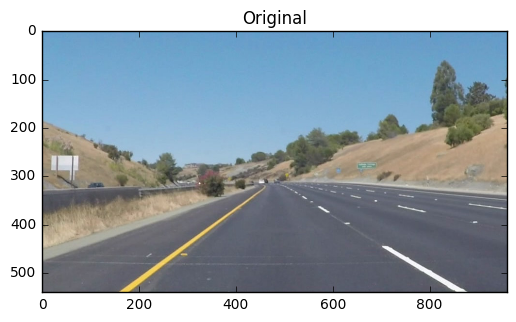

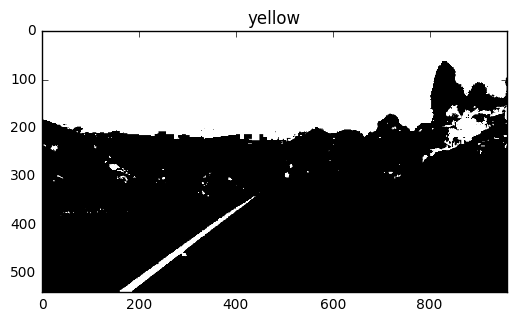

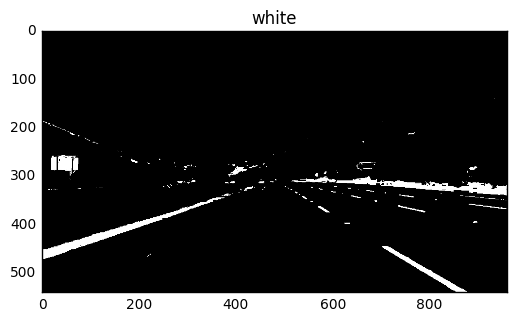

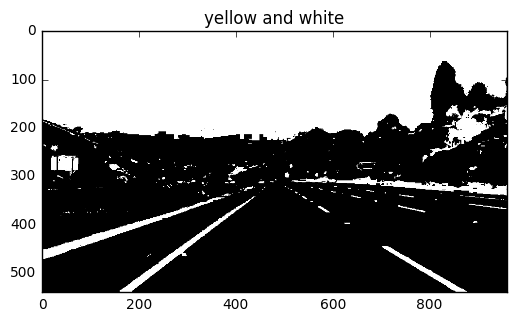

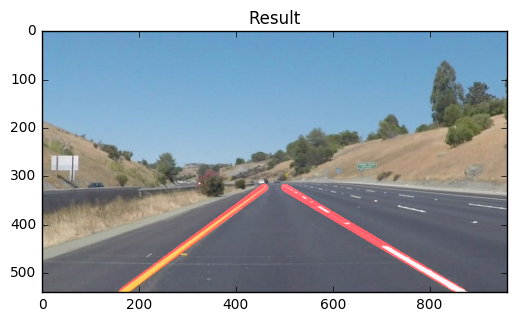

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

imgList = os.listdir("test_images/")
# for imgName  in imgList:
img = mpimg.imread("test_images/"+imgList[5])
plt.figure()
plt.imshow(img)
plt.title("Original")

print("Size of the image :",img.shape)
h,w = img.shape[0],img.shape[1]

min_y = 0.55*h
max_y =h

#---CONVERT TO HSV SPACE----
img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
#---FIND YELLOW PART----
# --------------use hsv_py.py to determinate range----------NEED SOME TIME TO FIND A GOOD VALUE---------
yellow = cv2.inRange(img_hsv, (0, 80, 0), (180, 255, 255))

plt.figure()
plt.imshow(yellow,cmap='gray')
plt.title("yellow")

#---FIND WHITE PART----
# --------------use hsv_py.py to determinate range----------NEED SOME TIME TO FIND A GOOD VALUE---------
white = cv2.inRange(img_hsv, (20, 0, 160), (180, 30, 255))

plt.figure()
plt.imshow(white,cmap='gray')
plt.title("white")

#---YELLOW ADD WHITE-----
img_or = cv2.bitwise_or(yellow,white)

plt.figure()
plt.imshow(img_or,cmap='gray')
plt.title("yellow and white")

# gray = grayscale(img_or)
gray = gaussian_blur(img_or,5)

# plt.figure()
# plt.imshow(gray,cmap="gray")


edge = canny(gray,50,150)

# plt.figure()
# plt.imshow(edge,cmap="gray")
# plt.title("edge")


#---------define a mask and apply it------------------
#---------DEFINE THE ROI REGION---NEED SOME TRIAL TO FIND A NICE ONE-------
# vertices = np.array([[[450,315],[500,315],[900,540],[120,540]]], dtype=np.int32)
# vertices = np.array([[[400,340],[550,340],[900,540],[100,540]]], dtype=np.int32)
vertices = np.array([[[0.35*w,min_y],[0.8*w,min_y],[0.95*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
m_edge = region_of_interest(edge,vertices)

plt.figure()
plt.imshow(m_edge,cmap="gray")
plt.title("roi edge")

# ---------def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):----------------
lines = hough_lines(m_edge,1,np.pi/180,20,15,200)

lines_img = weighted_img(img,lines)
    
plt.imshow(lines_img) 
plt.title("Result")
   



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```

In [20]:
# import imageio
# imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    h,w = image.shape[0],image.shape[1]
    #----------------USE JUST ROI---------NOT GOOD-------
    #     gray = grayscale(image)
    # #     gray = cv2.equalizeHist(gray)
    #     gray = gaussian_blur(gray,3)
    #     edge = canny(gray,50,150)

    # ----------------USE HSV------------BETTER----------------     
    img_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # --------------use hsv_py.py to determinate range----------NEED SOME TIME TO FIND A GOOD VALUE---------
    #     yellow = cv2.inRange(img_hsv, (0,100 , 190), (180, 255, 255))
    #     white = cv2.inRange(img_hsv, (0, 0, 190), (180, 255, 255))
    yellow = cv2.inRange(img_hsv, (0,100 , 170), (180, 255, 255))
    white = cv2.inRange(img_hsv, (0, 0, 220), (180, 255, 255))
    img_or = cv2.bitwise_or(yellow,white)
    edge = canny(img_or,50,150) 
    
    # min_y = 320
    #max_y = image.shape[0]-50
    min_y = 0.55*h
    max_y =h
    #---------define a mask and apply it------------------
    #---------DEFINE THE ROI REGION---NEED SOME TRIAL TO FIND A NICE ONE-----IT TAKES  SOME TIME----
    #     vertices = np.array([[[400,min_y],[550,min_y],[920,max_y],[100,max_y]]], dtype=np.int32)
    # vertices = np.array([[[700,min_y],[800,min_y],[1100,max_y],[100,max_y]]], dtype=np.int32)
    #     vertices = np.array([[[0.4*w,min_y],[0.8*w,min_y],[0.95*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
    vertices = np.array([[[0.4*w,min_y],[0.7*w,min_y],[0.9*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
    m_edge = region_of_interest(edge,vertices)
    
    # def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = hough_lines(m_edge,1,np.pi/180,15,15,600)
    result = weighted_img(image,lines) 
    

    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 12.4 s, sys: 40 ms, total: 12.5 s
Wall time: 6.11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [441]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [439]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 51.1 s, sys: 576 ms, total: 51.7 s
Wall time: 22.9 s


In [442]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge 

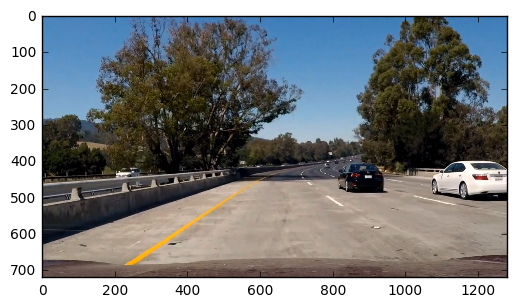

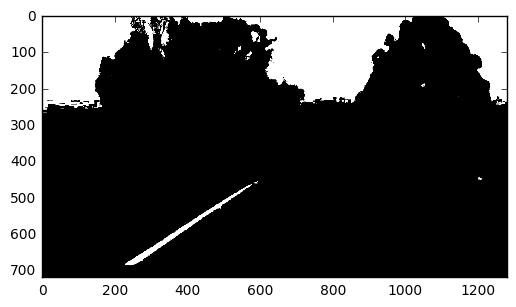

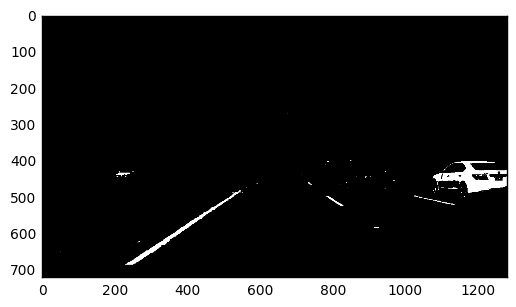

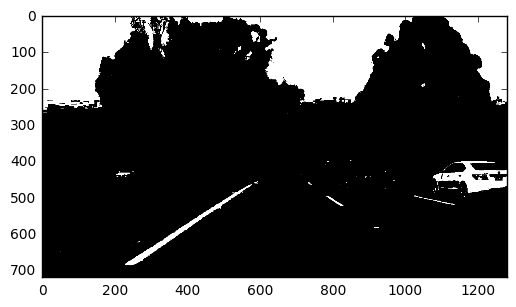

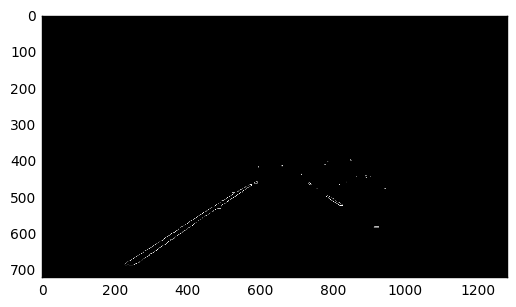

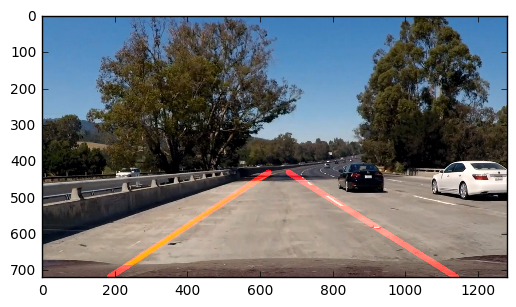

In [433]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# img = cv2.imread('challenge/'+'shot000'+str(7)+'.png')
img = cv2.imread('challenge/'+'c'+str(24)+'.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.uint8(img)
plt.imshow(img)
plt.figure()

h,w = img.shape[0],img.shape[1]
#     plt.imshow(image)
#     plt.show()
#  save challenge image
#     global cnt
#     if cnt % 1000 == 0:
#         cv2.imwrite('challenge/'+str(cnt)+'.jpg',cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
#         cnt += 1
#     return image 

# ----------------USE HSV------------BETTER------------        
img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
# use hsv_py.py to determinate range
yellow = cv2.inRange(img_hsv, (0,100 , 170), (180, 255, 255))
plt.imshow(yellow,cmap='gray')
plt.show()
white = cv2.inRange(img_hsv, (0, 0, 220), (180, 255, 255))
plt.imshow(white,cmap='gray')
plt.show()
img_or = cv2.bitwise_or(yellow,white)
plt.imshow(img_or,cmap='gray')
plt.show()
edge = canny(img_or,50,150) 

min_y = 0.55*h
max_y = h
#---------------define a mask and apply it--------
#  vertices = np.array([[[350/960*w,min_y],[550/960*w,min_y],[920/960*w,max_y],[60/930*w,max_y]]], dtype=np.int32)
# vertices = np.array([[[700,min_y],[800,min_y],[1100,max_y],[100,max_y]]], dtype=np.int32)
vertices = np.array([[[0.4*w,min_y],[0.7*w,min_y],[0.9*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
m_edge = region_of_interest(edge,vertices)
plt.imshow(m_edge,cmap='gray')
plt.show()
# def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
lines = hough_lines(m_edge,1,np.pi/180,15,15,600)
result = weighted_img(img,lines)

plt.imshow(result) 

   

In [438]:
def process_image_c(image):
    # ----------------USE HSV------------BETTER------------     
    img_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    #     yellow = cv2.inRange(img_hsv, (20, 40, 40), (30, 255, 255))
    #     white = cv2.inRange(img_hsv, (0, 0, 180), (180, 30, 255))
        # use hsv_py.py to determinate range
    #     yellow = cv2.inRange(img_hsv, (0,100 , 190), (180, 255, 255))
    #     white = cv2.inRange(img_hsv, (0, 0, 190), (180, 255, 255))
    yellow = cv2.inRange(img_hsv, (0,100 , 170), (180, 255, 255))
    white = cv2.inRange(img_hsv, (0, 0, 220), (180, 255, 255))
    img_or = cv2.bitwise_or(yellow,white)
    edge = canny(img_or,50,150) 
    

    # min_y = 320
    #max_y = image.shape[0]-50
    min_y = 0.55*h
    max_y =h
     # ---------define a mask and apply it-----------------
    #  vertices = np.array([[[0.4*w,min_y],[0.8*w,min_y],[0.95*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
    vertices = np.array([[[0.4*w,min_y],[0.7*w,min_y],[0.9*w,max_y],[0.15*w,max_y]]], dtype=np.int32)
    m_edge = region_of_interest(edge,vertices)
    
    # def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = hough_lines(m_edge,1,np.pi/180,15,15,600)
    result = weighted_img(image,lines) 
    
    return result

In [16]:

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [443]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))